In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader


In [41]:
def pre_process(data, var):
    
    Q = 60.0  - np.cumsum(data.I)
    data["Q"] = Q/1000
    return data[var]

def windows (data, window_size, stride):
    
    x = np.array(data)
    length = data.shape[0]
    windows_list = []
    
    for i in range(0, length-window_size, stride):
        windows_list.append(x[i:i+window_size][np.newaxis,:])
        
    return tuple(windows_list)


class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """
    
    def __init__(self, data, window_size, stride, scale = 0, max_list=[]):
        
        x_list = []
        y_list = []
        
        for i in range(0, len(data)-window_size, stride):             
            x_list.append(data[i:i+window_size, 1:][np.newaxis,:])
            #y_list.append(data[i:i+window_size, 0][np.newaxis,:])
            y_list.append(data[i+window_size,0])
        
        self.x = np.vstack(x_list)
        self.y = np.vstack(y_list)
        
        if scale:
           
            self.max_list = max_list
            
        else:
            self.max_y = np.max(self.y)
            self.max_list = [np.max(np.max(self.x, axis=1), axis=0), self.max_y]
        
        self.x = np.divide(self.x, self.max_list[0])
        self.y = self.y/self.max_list[1]
        
        print("x shape:", self.x.shape)
        print("y shape:", self.y.shape)
 

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.y.shape[0]

    def __add__(self, other):
        return ConcatDataset([self, other])
   
        
    
def mae(y_pred, y_true):
    loss = (torch.abs(y_pred - y_true)).mean()
    return loss    


In [12]:
class ResnetBlock(nn.Module):
    
    def __init__(self, n_input, kernel_sizes, n_filters):
        super().__init__()
        self.total_filters = n_filters*len(kernel_sizes)
        self.conv = nn.Conv1d(n_input, self.total_filters, kernel_size=1)
        self.bn = nn.BatchNorm1d(self.total_filters)
        self.conv_list1 = nn.ModuleList([  nn.Conv1d(n_input, n_filters, kernel_size, padding=int((kernel_size-1)/2)) for kernel_size in kernel_sizes])
        self.conv_list2 = nn.ModuleList([  nn.Conv1d(self.total_filters, n_filters, kernel_size,  padding=int((kernel_size-1)/2))  for kernel_size in kernel_sizes])
        self.bn1 = nn.BatchNorm1d(self.total_filters)
        self.bn2= nn.BatchNorm1d(self.total_filters)
        
    def forward(self, x):
        
        residual = self.bn(self.conv(x))
        x = torch.cat([nn.functional.pad(self.conv_list1[i](x), (0,1)) for i in range(len(self.conv_list1))], axis=1)
        x = F.relu(self.bn1(x))
        x = torch.cat([nn.functional.pad(self.conv_list2[i](x), (0,1)) for i in range(len(self.conv_list2))], axis=1)
        x = F.relu(self.bn2(x))
        x+= residual
        
        return x
    
    def to_cuda(self):
        
        for conv in self.conv_list1:
            conv.cuda()
            
        for conv in self.conv_list2:
            conv.cuda()
            
class ResnetRegressor(nn.Module):
    
    def __init__(self, n_input, forecast_length, backcast_length, kernel_sizes, n_filters = 33, hidden = 512, n_blocks = 4):
        
        super().__init__()
        self.n_input = n_input
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.kernel_sizes = kernel_sizes
        self.n_filters = n_filters
        self.hidden = hidden
        self.n_blocks = n_blocks
        
        total_filters = n_filters*len(kernel_sizes)
        self.total_filters = total_filters
        self.block1 = ResnetBlock(n_input, kernel_sizes, n_filters)
        self.blocks = nn.ModuleList()
        for block in range(n_blocks):
            self.blocks.append(ResnetBlock(total_filters, kernel_sizes, n_filters))

        self.feed_forward = nn.Linear(backcast_length*total_filters, hidden)
        self.feed_forward2 = nn.Linear(hidden, forecast_length)
                                          
        
        
    def forward(self, x):
        
        inp = x
        x = self.block1(x)
        for block in self.blocks:
            x = block(x)
        x = x.view(inp.shape[0], -1)
        x = F.relu(self.feed_forward(x))
        x = self.feed_forward2(x)
        return x
    

    def clone(self):
        clone = ResnetRegressor(self.n_input, 
                                self.forecast_length, 
                                self.backcast_length, 
                                self.kernel_sizes, 
                                self.n_filters, 
                                self.hidden,
                                self.n_blocks)
    
        clone.load_state_dict(self.state_dict())
        if self.is_cuda():
            clone.cuda()
            clone.to_cuda()
        return clone

    
    def forward2 (self, x, horizon):
        
        n_batches = x.shape[0]
        n_features = x.shape[1]
        n_backcast = x.shape[2]
        prediction = torch.zeros([n_batches, horizon*self.forecast_length])
        inp = x
        y_pred= self.forward(inp)
        prediction[:, 0:self.forecast_length] = y_pred
        
        print(x.shape, "x")
        for i in range(1,horizon):
            inp[:, 0 , :-self.forecast_length] = inp[:, 0, self.forecast_length:]
            inp[:, 0, -self.forecast_length:] = y_pred
            y_pred= self.forward(inp)
            prediction[:, self.forecast_length*i: self.forecast_length*(1+i)] = y_pred
            
        return prediction
            
        
    def to_cuda(self):
        
        self.block1.cuda()
        self.block1.to_cuda()
        for block in self.blocks:
            block.cuda()
            block.to_cuda()


In [42]:

var = ["U", "T", "I", "Q"]
path = "C:/Users/Sebastian/Documents/Data Analytics Master/Semester4-Thesis/Datasets/Battery-data/vw/DataLake/DataLake/0/EH_AgingStatus_0Y_Temp_1_rndLC_p.csv"

In [43]:
data = pd.read_csv(path)
data = pre_process(data, var)
data.head()

,U,T,I,Q
0,4.250048,1.0,0.0,0.06
1,4.250048,1.0,0.0,0.06
2,4.250048,1.0,0.0,0.06
3,4.250048,1.0,0.0,0.06
4,4.250048,1.0,0.0,0.06


In [44]:
stride = 20
window_size = 20
backcast = window_size
batch_size = 500
forecast = 1
train_split = int(len(data)*0.6)
val_split = int(len(data)*0.8)
batch_size = 1024
seq_len = backcast
output_dim = forecast
input_dim = 3
n_layers = 2
hidden_dim = 10

In [45]:
data = np.array(data)

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0}

idx = np.arange(len(data))

#dont apply it for time series
#np.random.shuffle(idx)

train_idx = idx[:train_split]
val_idx = idx[train_split:val_split]
test_idx = idx[val_split:]

train_dataset = Dataset(data[train_idx], window_size, stride)
train_loader = DataLoader(train_dataset, **params)
train_iter = iter(train_loader)

test_dataset = Dataset(data[test_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list)
test_loader = DataLoader(test_dataset, **params)
test_iter = iter(test_loader)

val_dataset = Dataset(data[val_idx], window_size, stride, scale = 1, max_list = train_dataset.max_list)
val_loader = DataLoader(val_dataset, **params)
val_iter = iter(val_loader)

x shape: (8527, 20, 3)
y shape: (8527, 1)
x shape: (2842, 20, 3)
y shape: (2842, 1)
x shape: (2842, 20, 3)
y shape: (2842, 1)


In [46]:
n_filters = 5
kernel_sizes = [32, 16, 8, 4]
n_input = 3
n_output = forecast
n_blocks =1
hidden = 512 #len(kernel_sizes)*n_filters //10

In [47]:
model =  ResnetRegressor(n_input, forecast, backcast, kernel_sizes, n_filters, hidden, n_blocks).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
max_epochs = 100
val_loss_list = []
prev_loss = np.inf
for i in range(max_epochs):
    
    train_iter = iter(train_loader)
    train_loss = 0.0
    for x_train, y_train in train_iter:
        
        x_train = np.transpose(x_train, [0, 2, 1])
        model.zero_grad()
        x_train, y_train = torch.tensor(x_train).float().cuda(), torch.tensor(y_train).float().cuda()

        y_pred = model(x_train)
        loss = mae(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy()*x_train.shape[0]
    print("Train loss:", train_loss/len(train_dataset))
        
        
    val_loss = 0.0
    for x_val, y_val in val_loader:
        
        x_val = np.transpose(x_val, [0, 2, 1])
        x_val, y_val = torch.tensor(x_val).float().cuda(), torch.tensor(y_val).float().cuda()

        #if(x_val.shape[0]==batch_size):
        y_pred = model(x_val)
        val_loss += mae(y_pred, y_val).cpu().data.numpy()*x_val.shape[0]
    val_loss /= (len(val_dataset)*forecast)
    
    #if(val_loss>prev_loss):
    #    break
        
    prev_loss = val_loss
    val_loss_list.append(val_loss)
    print(val_loss)

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Train loss: 0.32723183300461034
0.2170942725114299


C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss: 0.10476864192215851
0.10669877247479832
Train loss: 0.048617432411868
0.1066721146749326
Train loss: 0.02825622297639939
0.1108856937893254
Train loss: 0.020788209676005098
0.1260368977473455
Train loss: 0.019968601411366443
0.1016410213123737
Train loss: 0.022004057601587048
0.11521846436116161
Train loss: 0.016814337239251322
0.11044180659048998
Train loss: 0.016289524499196316
0.11885701517333958
Train loss: 0.015549634702453876
0.11638327927068452
Train loss: 0.015474625085157765
0.11599826124312591
Train loss: 0.014349352153131925
0.11108243892219685
Train loss: 0.01746100696006693
0.10485806928018211
Train loss: 0.023154730901691786
0.11632429087963178
Train loss: 0.0166618440578083
0.10203639142094659
Train loss: 0.01851865181716215
0.12509722589271996
Train loss: 0.01828954189926669
0.10258519206455607
Train loss: 0.017360909123393525
0.12433179597423413
Train loss: 0.02005996907544266
0.10660828228969124
Train loss: 0.01936756601613712
0.10878467323870662
Train los

In [48]:
x = train_dataset.x[:10000]
y = train_dataset.y[:10000]
x = np.transpose(x, [0, 2, 1])
y_pred = model(torch.tensor(x).float().cuda())

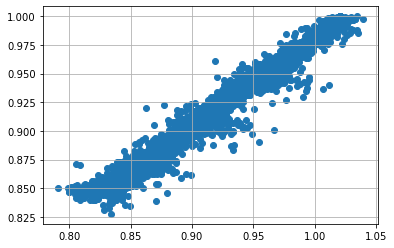

In [35]:
plt.scatter(y_pred.cpu().data.numpy(), y)
plt.grid()

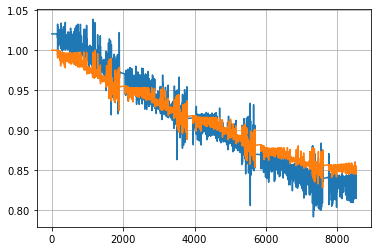

In [36]:
plt.plot(y_pred.cpu().data.numpy())
plt.plot(y)
plt.grid()

In [37]:
x = test_dataset.x[:10000]
y = test_dataset.y[:10000]
x = np.transpose(x, [0, 2, 1])
y_pred = model(torch.tensor(x).float().cuda())

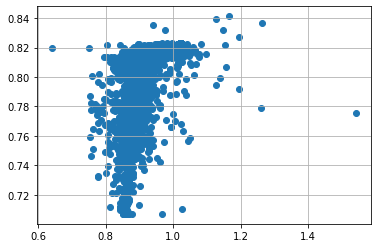

In [38]:
plt.scatter(y_pred.cpu().data.numpy(), y)
plt.grid()

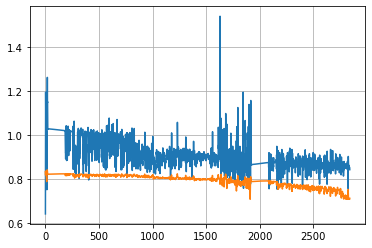

In [39]:
plt.plot(y_pred.cpu().data.numpy())
plt.plot(y)
plt.grid()